In [1]:
%matplotlib inline  
from __init__ import *
import numpy as np
import core.steps as steps
from core import data_store as ds
from core.common.ds_utils import print_ds_items_info
from core.evaluation.retrieval_perfomance import extract_perfomances_from_arr
from core.common.path_helper import DataStoreHelper
from core.quantization.pq_quantizer import build_pq_params_str, extract_pq_params_from_str
import math, os
%load_ext autoreload
%autoreload 2

In [2]:
ds_helper=DataStoreHelper(r'C:\data\computation\brodatz')

# Plot search types perfomance

In [3]:
def define_memory_per_descriptor(descriptor_name):
    if 'product' in descriptor_name or 'bincount' in descriptor_name:
        pq_params=ds_helper.extract_pq_params_from_descriptor_name(descriptor_name)
        m=pq_params['n_quantizers']
        K=pq_params['n_clusters']
        if 'product' in descriptor_name:
            mem=m*K*4
        elif 'bincount' in descriptor_name:
            mem=(K**m)*4
    elif 'lbp' in descriptor_name:
        mem=512*4
    elif 'hist' in descriptor_name:
        mem=256*4
    elif 'glcm' in descriptor_name:
        mem=256*256*4
   
    return mem

In [4]:
def build_mem_str(descriptor_name):
    mem=define_memory_per_descriptor(descriptor_name)
    if "bovw" in descriptor_name:
        pq_params=extract_pq_params_from_str(descriptor_name)
        pq_params_str=build_pq_params_str(pq_params)
        descriptor_name="bovw_{}".format(pq_params_str)
    mem_str="{}\n(bytes: {})".format(descriptor_name, mem)
    return mem_str

In [5]:
def plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, perfomance_type, n_nearest_cutoffs, save_to_file=False, bar=False):
    subplotname__label__x__y = {}
    label__kwargs={}
    for n_nearest_cutoff in n_nearest_cutoffs:
        label__x__y = subplotname__label__x__y.setdefault(n_nearest_cutoff,{})
        for pq_params in pq_params_arr:
            x_arr=[build_mem_str(descriptor_name) for descriptor_name in descriptor_names]
            ex_y_arr=[]
            sdc_y_arr=[]
            adc_y_arr=[]
            imi_y_arr=[]
            for descriptor_name in descriptor_names:
                ex_perfomances_ds=ds_helper.ex_search_perfomances_ds(descriptor_name)
                sdc_perfomances_ds=ds_helper.pq_search_perfomances_plot_path('sdc', descriptor_name, perfomance_type)
                adc_perfomances_ds=ds_helper.pq_search_perfomances_plot_path('adc', descriptor_name, perfomance_type)
                imi_perfomances_ds=ds_helper.pq_search_perfomances_plot_path('imi', descriptor_name, perfomance_type)

                ex_perfomances_ds=ds_helper.ex_search_perfomances_ds(descriptor_name)
                perfomances_arr=ds_helper.perfomance_arr(ex_perfomances_ds)
                y = extract_perfomances_from_arr(perfomances_arr, perfomance_type)[n_nearest_cutoff-1]
                ex_y_arr.append(y)

                perfomances_ds=ds_helper.pq_search_perfomances_ds('sdc', descriptor_name, pq_params)
                perfomances_arr=ds_helper.perfomance_arr(perfomances_ds)
                y = extract_perfomances_from_arr(perfomances_arr, perfomance_type)[n_nearest_cutoff-1]
                sdc_y_arr.append(y)

                perfomances_ds=ds_helper.pq_search_perfomances_ds('adc', descriptor_name, pq_params)
                perfomances_arr=ds_helper.perfomance_arr(perfomances_ds)
                y = extract_perfomances_from_arr(perfomances_arr, perfomance_type)[n_nearest_cutoff-1]
                adc_y_arr.append(y)

                perfomances_ds=ds_helper.pq_search_perfomances_ds('imi', descriptor_name, pq_params)
                perfomances_arr=ds_helper.perfomance_arr(perfomances_ds)
                y = extract_perfomances_from_arr(perfomances_arr, perfomance_type)[n_nearest_cutoff-1]
                imi_y_arr.append(y)

            ex_x__y=dict(zip(x_arr,ex_y_arr))
            sdc_x__y=dict(zip(x_arr,sdc_y_arr))
            adc_x__y=dict(zip(x_arr,adc_y_arr))
            imi_x__y=dict(zip(x_arr,imi_y_arr))

            label__x__y['exh']=ex_x__y
            label__x__y['sdc'+'-'+build_pq_params_str(pq_params)]=sdc_x__y
            label__x__y['adc'+'-'+build_pq_params_str(pq_params)]=adc_x__y
            label__x__y['imi'+'-'+build_pq_params_str(pq_params)]=imi_x__y


            label__kwargs['exh']={'markersize':9.0}
            label__kwargs['sdc'+'-'+build_pq_params_str(pq_params)]={'markersize':9.0}
            label__kwargs['adc'+'-'+build_pq_params_str(pq_params)]={'markersize':9.0}
            label__kwargs['imi'+'-'+build_pq_params_str(pq_params)]={'markersize':9.0}

    #         label__kwargs[0]={'linewidth':3.0}
    
    if save_to_file:
        plot_path=ds_helper.pq_search_perfomances_plot_path(search_type, descriptor_name, perfomance_type)
    else:
        plot_path=None
#     label_callback=lambda label: 'original' if label==0 else 'm = {}'.format(label)
    steps.plotting_step3(subplotname__label__x__y, 'n_nearest: ', str, '', perfomance_type, save_to_file=plot_path, label__kwargs=label__kwargs, bar=bar)

In [6]:
n_nearest_cutoffs=[1,5,10,25]

In [7]:
descriptor_names=['histograms', 'lbphistograms', 'glcms']
choosen_bovwproductbincounts_pq_params= [{'n_clusters': K, 'n_quantizers': m} for K,m in [(64,4),(128,1),(16,1)]]
descriptor_names+=ds_helper.bovw_descriptors_names('bovwproductbincounts',choosen_bovwproductbincounts_pq_params)

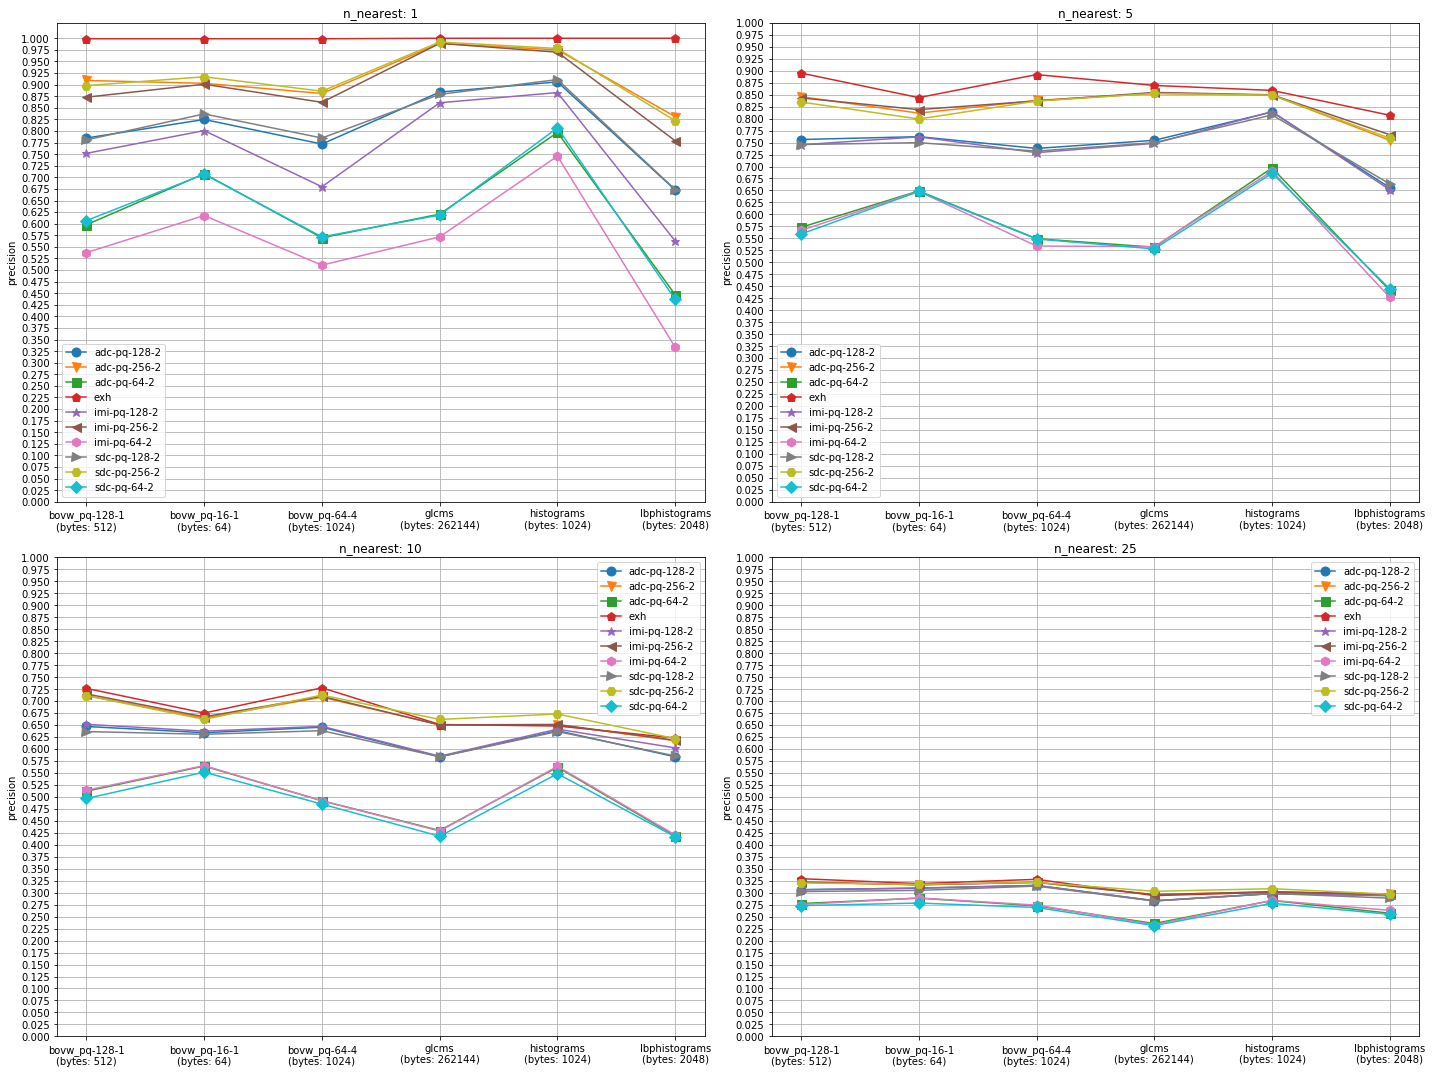

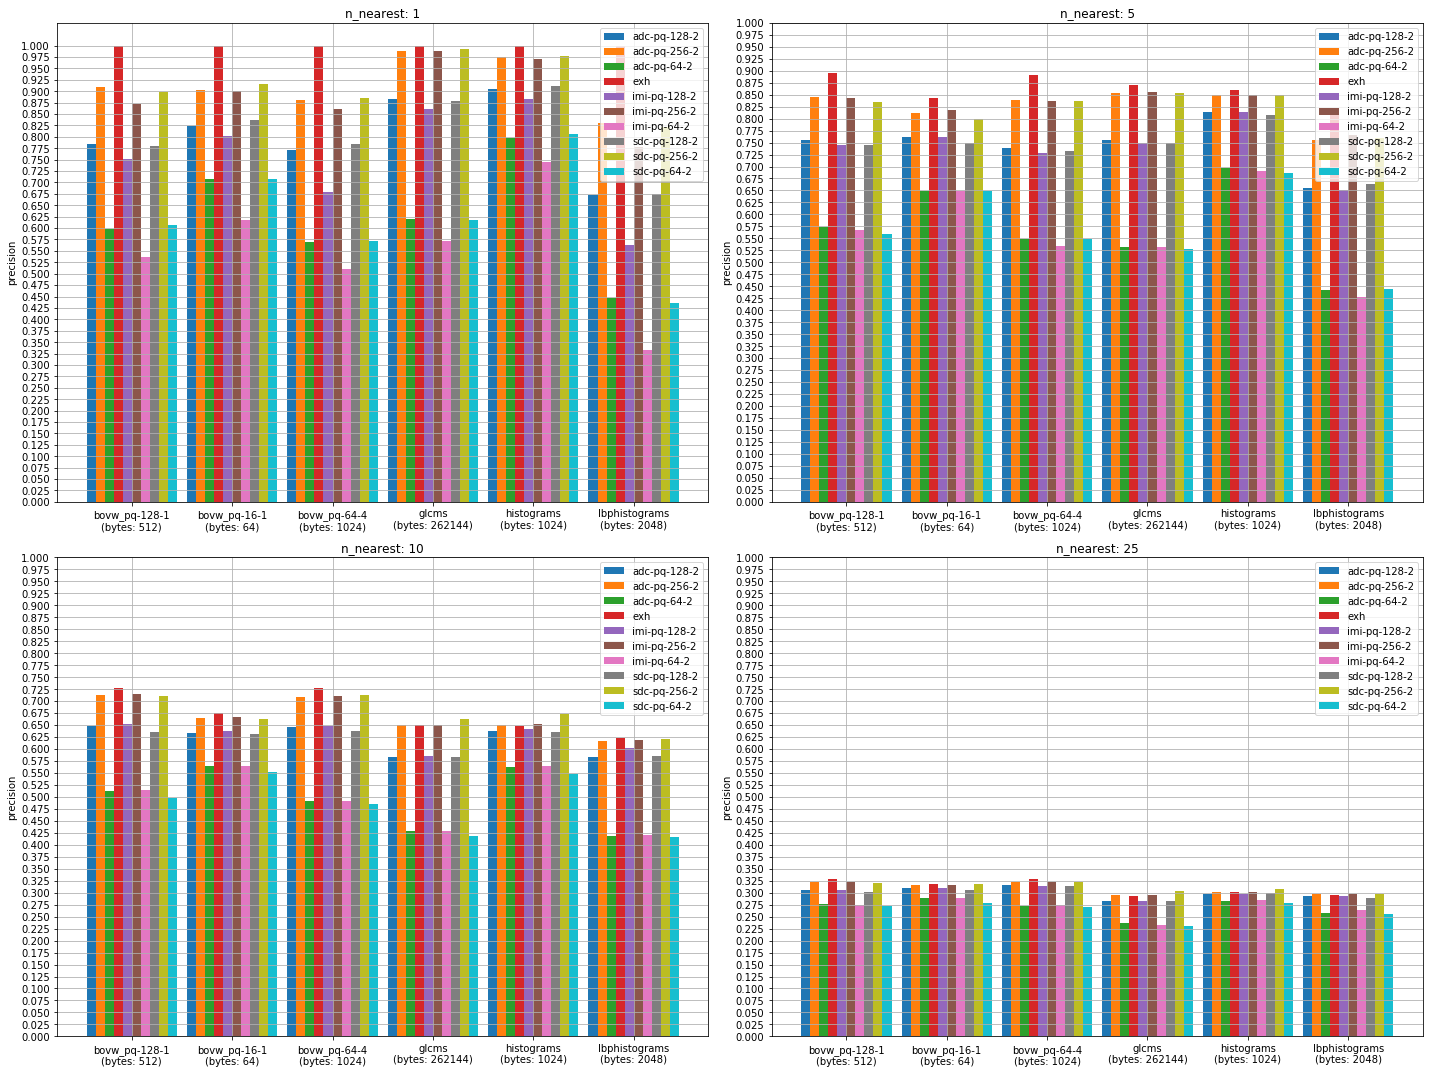

In [8]:
pq_params_arr = [{'n_clusters': K, 'n_quantizers': m} for K,m in [(64, 2),(128, 2),(256, 2)]]
plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, 'precision', n_nearest_cutoffs, False)
plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, 'precision', n_nearest_cutoffs, False, bar=True)

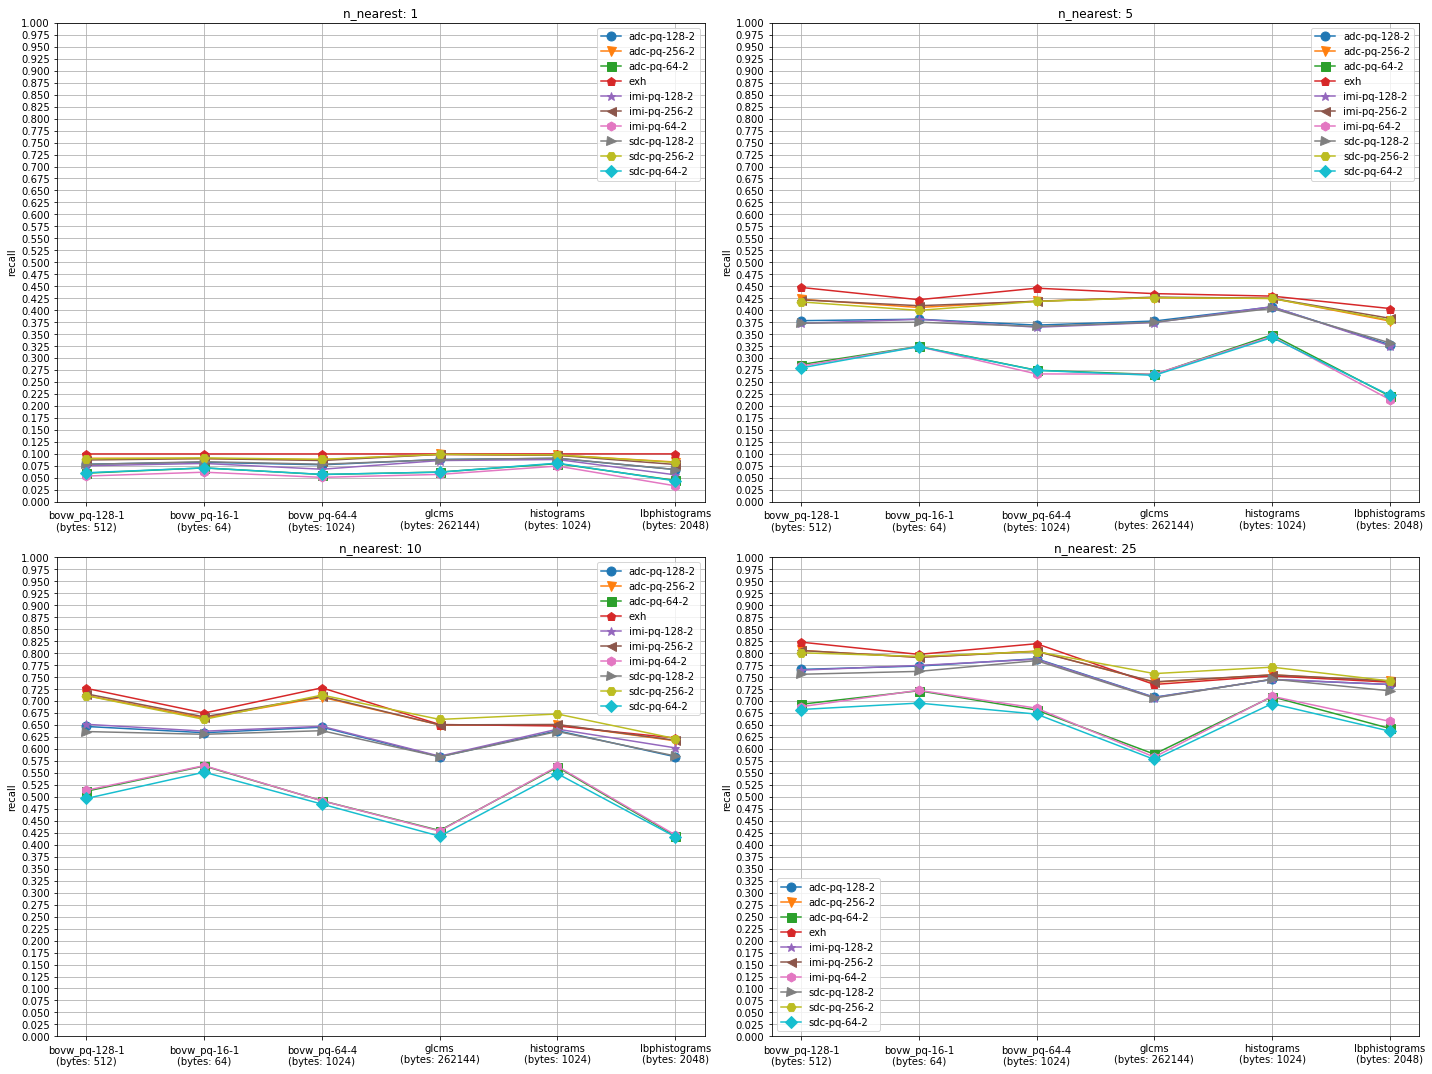

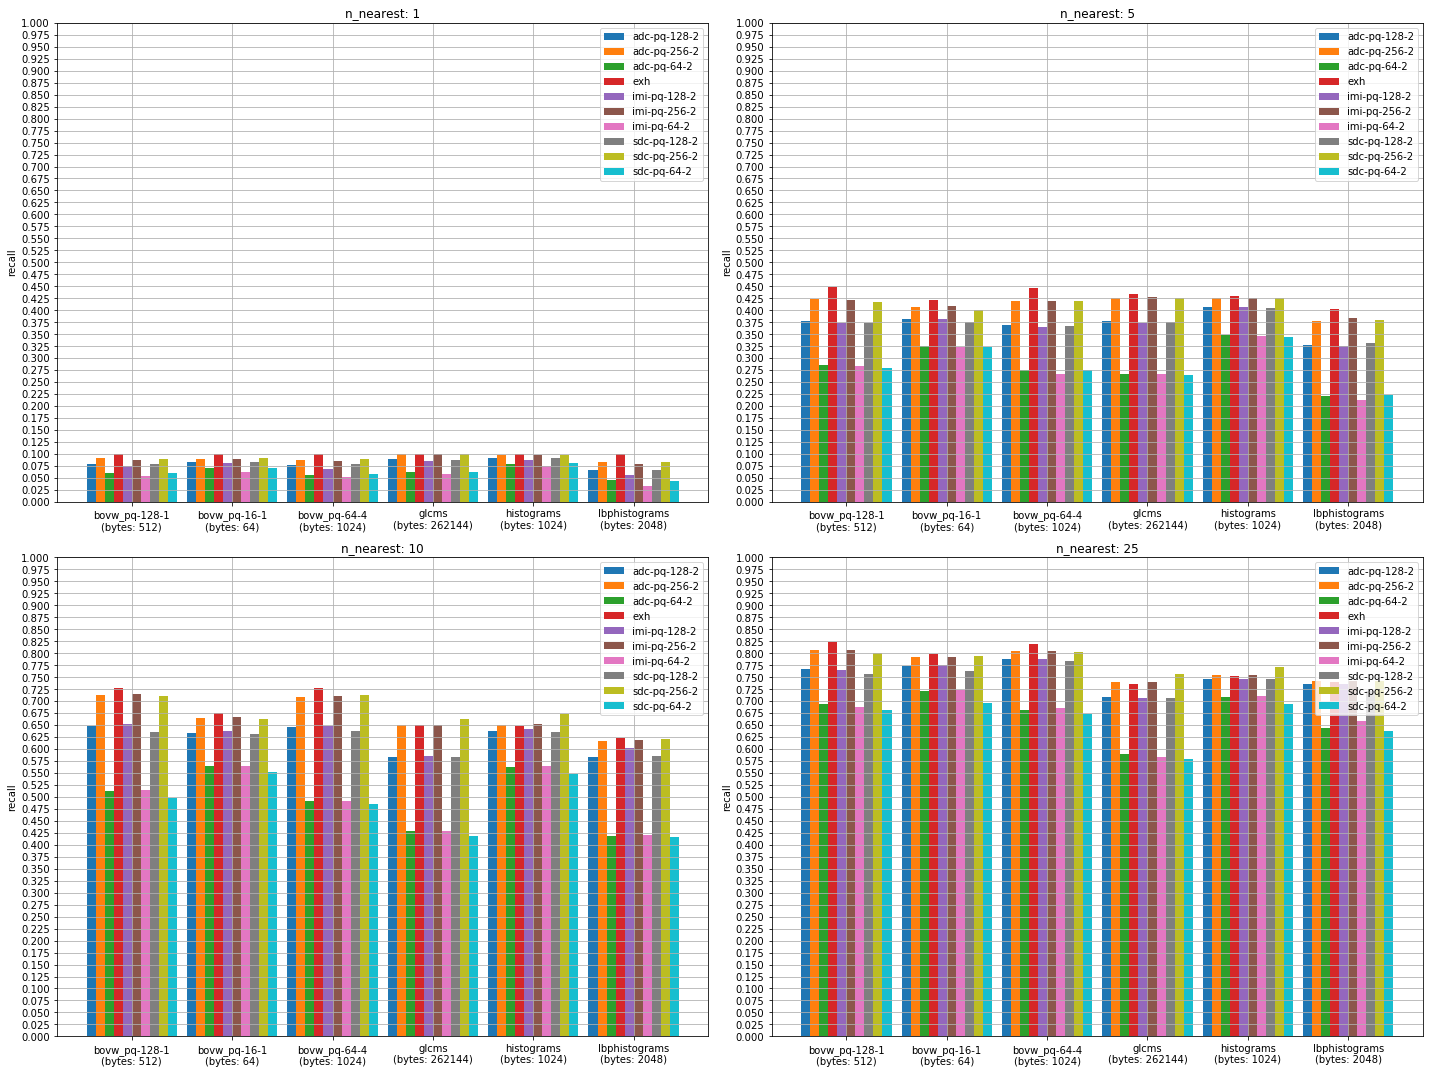

In [9]:
pq_params_arr = [{'n_clusters': K, 'n_quantizers': m} for K,m in [(64, 2),(128, 2),(256, 2)]]
plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, 'recall', n_nearest_cutoffs, False)
plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, 'recall', n_nearest_cutoffs, False, bar=True)

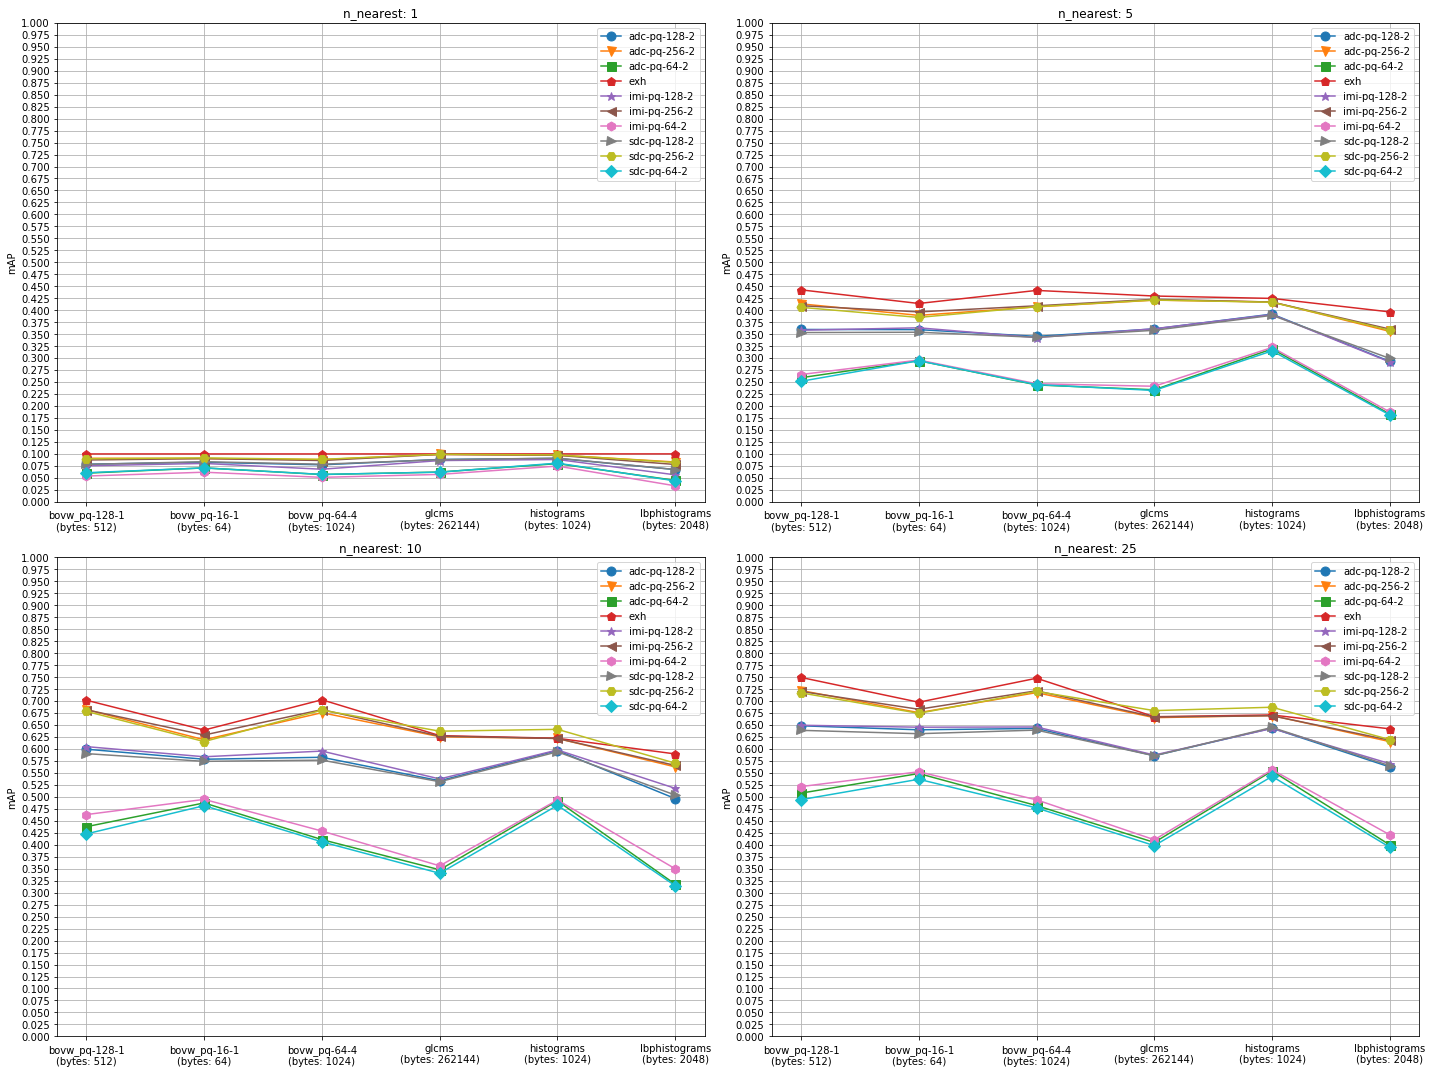

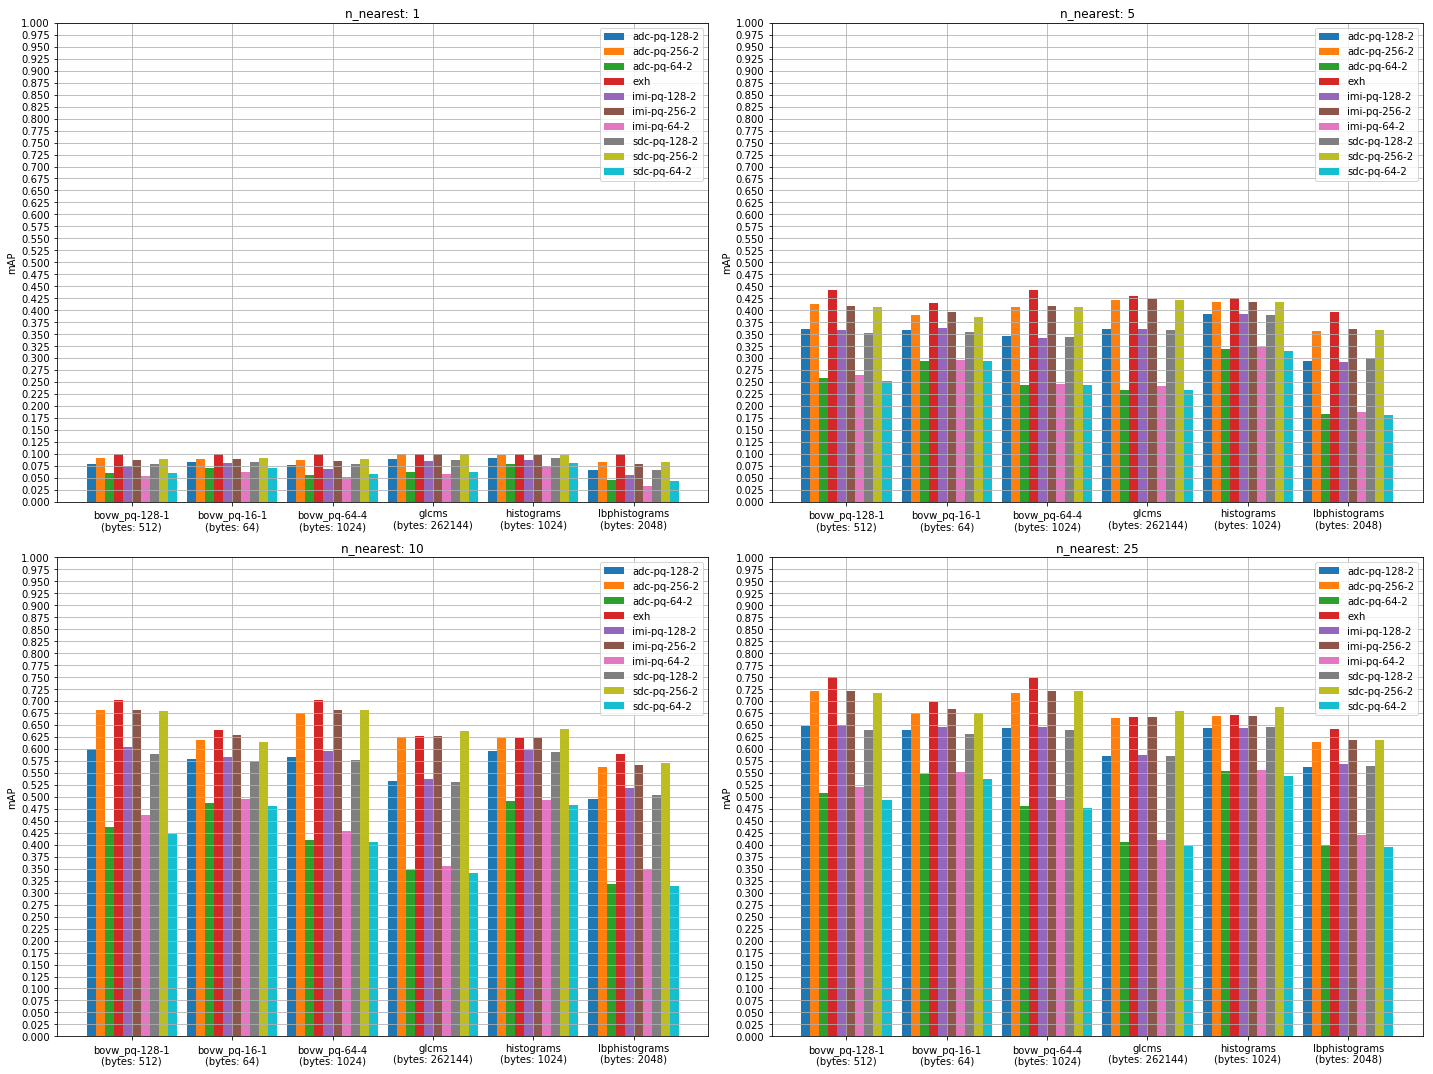

In [10]:
pq_params_arr = [{'n_clusters': K, 'n_quantizers': m} for K,m in [(64, 2),(128, 2),(256, 2)]]
plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, 'mAP', n_nearest_cutoffs, False)
plot_pq_search_params_perfomance(descriptor_names, pq_params_arr, 'mAP', n_nearest_cutoffs, False, bar=True)

Prodcut quantization approach and search types based on it are only 0.025-0.05 worser than exhaustive straightforward search.
Even imi(inverted multi-index) search which is approximate search shows good results.